In [2]:
import pandas as pd
from xml.etree import ElementTree
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers
from keras import models
from collections import Counter
from math import ceil, floor
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras.layers import Dropout, Conv2D, BatchNormalization, MaxPooling2D , Activation, MaxPooling3D
import os
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed, LSTM, Dense, ConvLSTM2D, Bidirectional
import pickle

In [3]:
vid_names = ['movie1gel1', 'movie1gel2', 'movie2gel1', 'movie2gel2', 'movie3gel1', 'movie3gel2']
conc = {0: 0.2, 1: 0.28, 2: 0.36, 3: 0.44, 4: 0.52, 5: 0.6, 6: 0.68, 7: 0.76, 8: 0.84, 9: 0.92, 10: 1}
conc_reverse = dict(map(reversed,conc.items()))

In [4]:
train_vids = ['movie1gel1', 'movie2gel1', 'movie3gel1', 'movie3gel2']
train_paths = list()

no_files = 0
for vid in train_vids:
    for i in range(11):
        no_files += len(os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)))
        for file in os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)):
            train_paths.append('sequences_per_video_100x100/'+vid+'/'+str(i)+'/'+file)
        
def batch_generator_from_memory(train_files, batch_size = 100):
    indices = np.arange(len(train_files))
    X = list()
    Y = list()
    while True:
        np.random.shuffle(indices)
        for i in indices:
            aux = np.load(train_files[i], allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [5]:
val_vids = ['movie1gel2']
val_paths = list()

no_val_files = 0
for vid in val_vids:
    for i in range(11):
        no_val_files += len(os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)))
        for file in os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)):
            val_paths.append('sequences_per_video_100x100/'+vid+'/'+str(i)+'/'+file)

def validation_generator(train_files, batch_size = 1):
    indices = np.arange(len(train_files))
    X = list()
    Y = list()
    while True:
        for i in indices:
            aux = np.load(train_files[i], allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [6]:
def prof_LSTM(n_kernels, k_dim, init_stride, lstm_units, bi):  
    model = models.Sequential()
    model.add(TimeDistributed(Conv2D(n_kernels[0], (k_dim, k_dim), strides=(init_stride, init_stride), activation='relu', padding='same'), input_shape=(78,100,100,3)))
    model.add(TimeDistributed(Conv2D(n_kernels[0], (k_dim, k_dim),padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Conv2D(n_kernels[1], (k_dim, k_dim),padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(n_kernels[1], (k_dim, k_dim),padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Conv2D(n_kernels[2], (k_dim, k_dim),padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(n_kernels[2], (k_dim, k_dim),padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(layers.Flatten()))
    model.add(Dropout(0.5))
    if bi == False:
        model.add(LSTM(lstm_units, return_sequences=False, dropout=0.5))
    else:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=0.5)))
    model.add(Dense(1))
    model.summary()
    
    return model

In [7]:
n_kernels = [(8,16,32)]
k_dim = [3]
init_stride = [2]
lstm_units = [32]
bidir = [True]
params = list()

for nk in n_kernels:
    for kd in k_dim:
        for init_s in init_stride:
            for lstm_u in lstm_units:
                for bd in bidir:
                    params.append((nk,kd,init_s, lstm_u,bd))

In [8]:
no_files

4513

In [9]:
batch_size = 35
num_samples = no_files

for i in range(len(params)):
    model = prof_LSTM(params[i][0], params[i][1], params[i][2], params[i][3], params[i][4])
    save_folder = './CNN2D_LSTM_prof_regression_logs_changed_sets/net_'+str(i)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    csv = CSVLogger(save_folder +'/training.log')
    tb = TensorBoard(update_freq='epoch', log_dir = save_folder)
    weigths_name="best_weights.h5"
    mc = ModelCheckpoint(save_folder+'/'+weigths_name, monitor='val_loss', mode='min', save_best_only=True)
    cbs = [mc, es, tb, csv]
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    history = model.fit_generator(batch_generator_from_memory(train_paths, batch_size = batch_size), 
              steps_per_epoch = ceil(num_samples / batch_size), epochs = 1000, validation_data = validation_generator(val_paths), validation_steps = no_val_files, 
              callbacks = cbs)
    
    f = open(save_folder+"/model_specs.txt", "a")
    f.write(str(params[i]))
    f.close()
    break

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 78, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 78, 50, 50, 8)     584       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 78, 25, 25, 8)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 78, 25, 25, 16)    1168      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 78, 25, 25, 16)    2320      
_________________________________________________________________
time_distributed_6 (T

# ANALYSIS

In [11]:
#NAAAAOOOOO CORRER MAAAAAAAAAAIS##########################
val_preds = {}
sizes = {}

for model_ in ['net_0']:
    print(model_)
    val_preds[model_] = {}
    sizes[model_] = {}
    for i in range(11):
        print(i)
        cur_path = 'sequences_per_video_100x100/movie1gel2/'+str(i)
        seqs = list()
        sizes_list = list()
        for file in sorted(os.listdir(cur_path)):
            aux = np.load(cur_path+'/'+file, allow_pickle = True)
            seqs.append(aux[0]/255)
            sizes_list.append(aux[2])
        model = models.load_model('CNN2D_LSTM_prof_regression_logs_changed_sets/'+model_+'/best_weights.h5')
        val_preds[model_][i] = model.predict(np.asarray(seqs))
        sizes[model_][i] = sizes_list

net_0
0
1
2
3
4
5
6
7
8
9
10


In [4]:
#with open('val_preds_LSTM_prof_changed_sets.pkl', 'wb') as f:
#    pickle.dump((val_preds, sizes), f)
    
    
with open('val_preds_LSTM_prof_changed_sets.pkl', 'rb') as f: 
    aux = pickle.load(f)
    
val_preds = aux[0]
sizes = aux[1]

In [13]:
concs_real = list()

for i in range(11):
    concs_real.append(conc[i])

In [6]:
#mse per model per conc
mse_cat = {}

for model_ in val_preds:
    mse_cat[model_] = {}
    for i in range(11):
        mse_cat[model_][i] = 0
        for j in range(len(val_preds[model_][i])):
            mse_cat[model_][i] += (conc[i] - val_preds[model_][i][j][0]) ** 2
        mse_cat[model_][i] /= len(val_preds[model_][i])

In [7]:
#mse per conc (mean between all models)
mse_conc = {}

for i in range(11):
    mse_conc[i] = 0

for key in mse_cat:
    for i in range(11):
        mse_conc[i] += mse_cat[key][i]
        
for key in mse_conc:
    mse_conc[key] /= len(mse_cat.keys())

In [8]:
mean_preds = {}
for mod in val_preds:
    mean_preds[mod] = list()
    for i in range(11):
        aux = 0
        for j in range(len(val_preds[mod][i])):
            aux += val_preds[mod][i][j][0]
        mean_preds[mod].append(aux / len(val_preds[mod][i]))

In [9]:
preds_clean = {}
preds_clean['x'] = list()
preds_clean['y'] = list()

for i in val_preds['net_0']:
    for j in val_preds['net_0'][i]:
        preds_clean['x'].append(conc[i])
        preds_clean['y'].append(j[0])

In [10]:
abs_mean_error = list()
for i in range(len(mean_preds['net_0'])):
    abs_mean_error.append(abs(mean_preds['net_0'][i] - conc[i]))
abs_mean_error

[0.04675595133819363,
 0.018755380409684996,
 0.02280478373847228,
 0.013008760105479855,
 0.0009674127874049754,
 0.024762421880256014,
 0.03789427161216741,
 0.06332085999046888,
 0.050896415099119574,
 0.017605512142181312,
 0.04251456423981548]

In [11]:
val_mae = list()
for i in range(len(preds_clean['x'])):
    val_mae.append(abs(preds_clean['x'][i] - preds_clean['y'][i]))
    
val_mae = np.mean(val_mae)
val_mae

0.06053842389389224

No handles with labels found to put in legend.


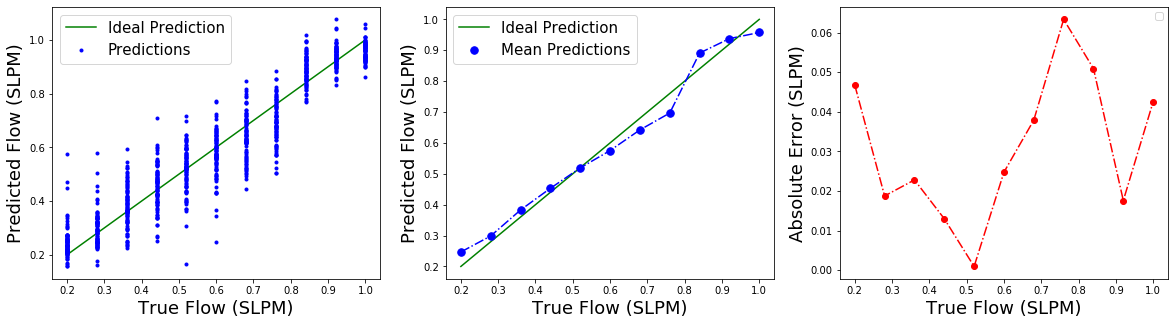

In [12]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
mod = 'net_0'
fs = 18

axs[0].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')

axs[0].plot(preds_clean['x'], preds_clean['y'], 'bo', markersize=3, label = 'Predictions')
        
axs[1].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')
axs[1].plot(concs_real, mean_preds[mod], 'b-.')
axs[1].plot(concs_real, mean_preds[mod], 'b.', markersize=15, label = 'Mean Predictions')

axs[0].legend(loc=0, fontsize=15)
axs[1].legend(loc=0, fontsize=15)
axs[2].legend(loc=0)
axs[0].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[0].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[1].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[1].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[2].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[2].set_ylabel('Absolute Error (SLPM)', fontsize = fs)

axs[2].plot(concs_real, abs_mean_error, 'r-.')
axs[2].plot(concs_real, abs_mean_error, 'ro')

In [13]:
with open('LSTM_prof_changed_sets_ALL_VARIABLES.pkl', 'wb') as f:
    pickle.dump((mse_cat, mse_conc, mean_preds, preds_clean, abs_mean_error, val_mae), f)

In [14]:
mse_cat

{'net_0': {0: 0.005971281371924808,
  1: 0.0045272970358007725,
  2: 0.006836376800097221,
  3: 0.006893379843684378,
  4: 0.00745862350714313,
  5: 0.008099906901674782,
  6: 0.008884692257982739,
  7: 0.010852930001414048,
  8: 0.005478183357729354,
  9: 0.002049360788038932,
  10: 0.0030156699718349254}}

# YOLO

In [21]:
#NAAAAOOOOO CORRER MAAAAAAAAAAIS##########################
val_preds = {}
sizes = {}

for model_ in ['net_0']:
    print(model_)
    val_preds[model_] = {}
    sizes[model_] = {}
    for i in range(11):
        print(i)
        cur_path = 'sequences_per_video_100x100/movie2gel2/'+str(i)
        seqs = list()
        sizes_list = list()
        for file in sorted(os.listdir(cur_path)):
            aux = np.load(cur_path+'/'+file, allow_pickle = True)
            seqs.append(aux[0]/255)
            sizes_list.append(aux[2])
        model = models.load_model('CNN2D_LSTM_prof_regression_logs_changed_sets/'+model_+'/best_weights.h5')
        val_preds[model_][i] = model.predict(np.asarray(seqs))
        sizes[model_][i] = sizes_list

net_0
0
1
2
3
4
5
6
7
8
9
10


In [4]:
#with open('YOLO_preds_LSTM_prof_changed_sets.pkl', 'wb') as f:
#    pickle.dump((val_preds, sizes), f)
    
    
with open('YOLO_preds_LSTM_prof_changed_sets.pkl', 'rb') as f: 
    aux = pickle.load(f)
    
val_preds = aux[0]
sizes = aux[1]

In [6]:
#mse per model per conc
mse_cat = {}

for model_ in val_preds:
    mse_cat[model_] = {}
    for i in range(11):
        mse_cat[model_][i] = 0
        for j in range(len(val_preds[model_][i])):
            mse_cat[model_][i] += (conc[i] - val_preds[model_][i][j][0]) ** 2
        mse_cat[model_][i] /= len(val_preds[model_][i])

In [7]:
#mse per conc (mean between all models)
mse_conc = {}

for i in range(11):
    mse_conc[i] = 0

for key in mse_cat:
    for i in range(11):
        mse_conc[i] += mse_cat[key][i]
        
for key in mse_conc:
    mse_conc[key] /= len(mse_cat.keys())

In [8]:
mean_preds = {}
for mod in val_preds:
    mean_preds[mod] = list()
    for i in range(11):
        aux = 0
        for j in range(len(val_preds[mod][i])):
            aux += val_preds[mod][i][j][0]
        mean_preds[mod].append(aux / len(val_preds[mod][i]))

In [9]:
preds_clean = {}
preds_clean['x'] = list()
preds_clean['y'] = list()

for i in val_preds['net_0']:
    for j in val_preds['net_0'][i]:
        preds_clean['x'].append(conc[i])
        preds_clean['y'].append(j[0])

In [10]:
abs_mean_error = list()
for i in range(len(mean_preds['net_0'])):
    abs_mean_error.append(abs(mean_preds['net_0'][i] - conc[i]))
abs_mean_error

[0.03032044822519475,
 0.01205679926005282,
 0.011644406219323444,
 0.033806656671292845,
 0.056468658905762914,
 0.0567070777377775,
 0.05291569034899435,
 0.04720098653147298,
 0.0956479567866172,
 0.04365754917019704,
 0.03910730412748997]

In [11]:
val_mae = list()
for i in range(len(preds_clean['x'])):
    val_mae.append(abs(preds_clean['x'][i] - preds_clean['y'][i]))
    
val_mae = np.mean(val_mae)
val_mae

0.0711180865773145

No handles with labels found to put in legend.


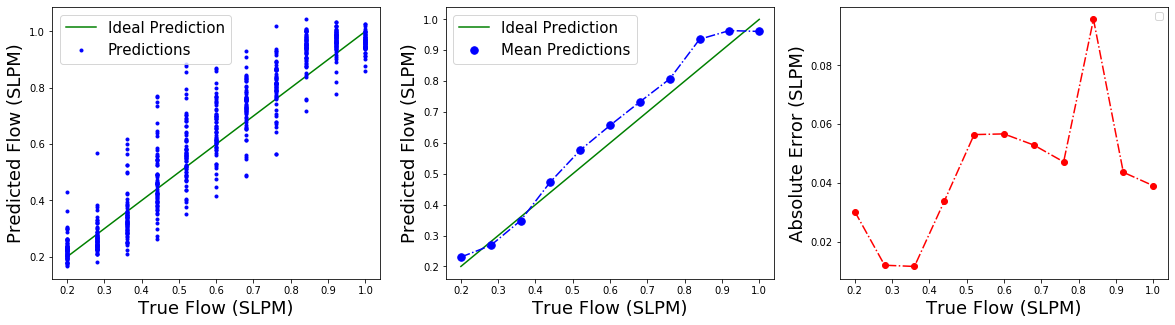

In [14]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
mod = 'net_0'
fs = 18

axs[0].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')

axs[0].plot(preds_clean['x'], preds_clean['y'], 'bo', markersize=3, label = 'Predictions')
        
axs[1].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')
axs[1].plot(concs_real, mean_preds[mod], 'b-.')
axs[1].plot(concs_real, mean_preds[mod], 'b.', markersize=15, label = 'Mean Predictions')

axs[0].legend(loc=0, fontsize=15)
axs[1].legend(loc=0, fontsize=15)
axs[2].legend(loc=0)
axs[0].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[0].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[1].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[1].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[2].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[2].set_ylabel('Absolute Error (SLPM)', fontsize = fs)

axs[2].plot(concs_real, abs_mean_error, 'r-.')
axs[2].plot(concs_real, abs_mean_error, 'ro')

In [24]:
with open('YOLO_LSTM_prof_changed_sets_ALL_VARIABLES.pkl', 'wb') as f:
    pickle.dump((mse_cat, mse_conc, mean_preds, preds_clean, abs_mean_error, val_mae), f)

# SIZE

In [15]:
diameters_sequences = list()
mae_per_droplet = list()
for i in sizes['net_0']:
    for j in range(len(sizes['net_0'][i])):
        diameters_sequences.append(sizes['net_0'][i][j])
        mae_per_droplet.append(abs(conc[i] - val_preds['net_0'][i][j][0]))

In [16]:
bins_ = [15, 25, 35 , 45, 55, 65]
#bins_ = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

mae_per_size = {}

for i in range(len(bins_) - 1):
    mae_per_size[i] = list()
    
for i in range(len(diameters_sequences)):
    for j in range(len(bins_) - 1):
        if diameters_sequences[i] < bins_[j+1]:
            mae_per_size[j].append(mae_per_droplet[i])
            break

aux_list = []
for i in range(len(bins_) - 1):
    if len(mae_per_size[i]) != 0:
        mae_per_size[i] = np.mean(mae_per_size[i])
        aux_list.append(i)
    else:
        mae_per_size[i] = np.nan

In [17]:
mae_per_size

{0: 0.09883970396154247,
 1: 0.07086718919384519,
 2: 0.048777110048315746,
 3: 0.04653526434392641,
 4: 0.09243536656553095}

In [18]:
#x_mps = [17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 72.5, 77.5]
x_mps = [20, 30, 40, 50, 60]
y_mps = list()
for i in range(len(aux_list)):
    y_mps.append(mae_per_size[aux_list[i]])

Text(0, 0.5, 'Absolute Error (SLPM)')

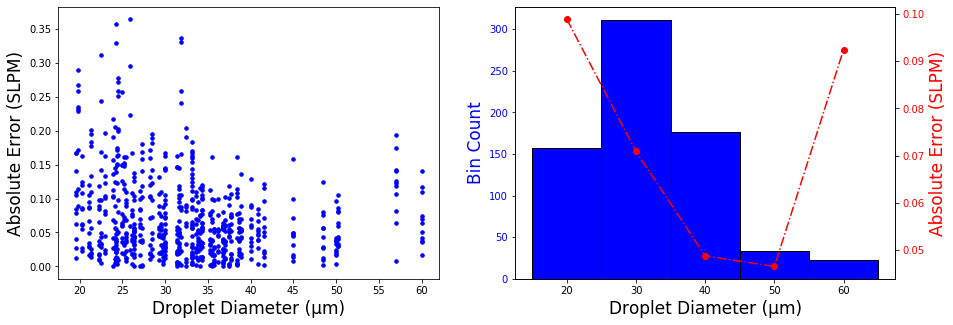

In [19]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fs = 17
ax2 = axs[1].twinx()

axs[0].plot(diameters_sequences, mae_per_droplet, 'bo', markersize=3.5)
axs[1].hist(diameters_sequences, color = 'blue', edgecolor = 'black',bins = bins_)
ax2.plot(x_mps, y_mps, 'r-.')
ax2.plot(x_mps, y_mps, 'ro')

color = 'r'
ax2.set_ylabel('Absolute Error (SLPM)', color = color, fontsize = fs)
ax2.tick_params(axis='y', labelcolor=color)
color = 'b'
axs[1].set_ylabel('Bin Count', color = color, fontsize = fs)
axs[1].set_xlabel('Droplet Diameter (μm)', fontsize = fs)
axs[1].tick_params(axis='y', labelcolor=color)
axs[0].set_xlabel('Droplet Diameter (μm)', fontsize = fs)
axs[0].set_ylabel('Absolute Error (SLPM)', fontsize = fs)

Text(0, 0.5, 'Absolute Error (SLPM)')

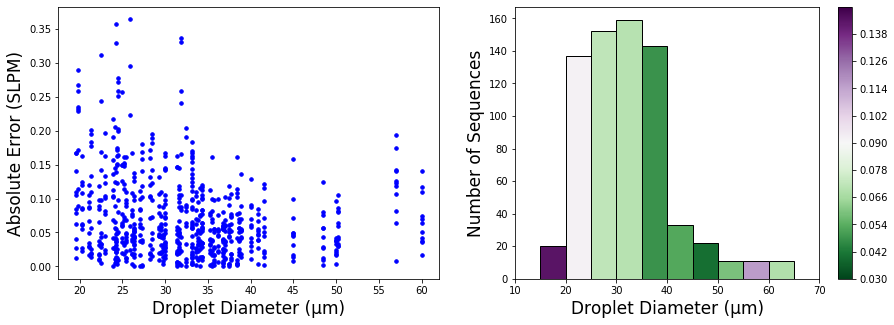

In [22]:
bins_ = [15, 20, 25, 30, 35 ,40, 45, 50, 55, 60, 65]
#bins_ = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

mae_per_size = {}

for i in range(len(bins_) - 1):
    mae_per_size[i] = list()
    
for i in range(len(diameters_sequences)):
    for j in range(len(bins_) - 1):
        if diameters_sequences[i] < bins_[j+1]:
            mae_per_size[j].append(mae_per_droplet[i])
            break

aux_list = []
for i in range(len(bins_) - 1):
    if len(mae_per_size[i]) != 0:
        mae_per_size[i] = np.mean(mae_per_size[i])
        aux_list.append(i)
    else:
        mae_per_size[i] = np.nan
        
        

x_mps = [17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5]
#x_mps = [20, 30, 40, 50, 60]
y_mps = list()
for i in range(len(aux_list)):
    y_mps.append(mae_per_size[aux_list[i]])




import pylab as pl
from matplotlib import cm

fig, axs = plt.subplots(1,2,figsize=(15,5))
fs = 17

axs[0].plot(diameters_sequences, mae_per_droplet, 'bo', markersize=3.5)
N, bins, patches = axs[1].hist(diameters_sequences, color = 'green', edgecolor = 'black',bins = bins_)
axs[1].set_ylabel('Number of Sequences', fontsize = fs)
axs[1].set_xlabel('Droplet Diameter (μm)', fontsize = fs)
axs[1].set_xlim([10,70])

aux = [(x-0.03)*8.33333 for x in list(mae_per_size.values())]
colors = cm.PRGn_r(aux)
#colors = cm.RdYlGn_r(aux)
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
  
fld=np.random.rand(2,2)+20
levels = np.linspace(0.03,0.15,1500)
img=plt.contourf(fld,levels=levels,cmap='PRGn_r')
plt.colorbar(img)    
    
#sm = plt.cm.ScalarMappable(cmap='PRGn')
#sm._A = []
#plt.colorbar(sm)    



axs[0].set_xlabel('Droplet Diameter (μm)', fontsize = fs)
axs[0].set_ylabel('Absolute Error (SLPM)', fontsize = fs)

In [21]:
list(mae_per_size.values())

[0.14396354562044145,
 0.0922522818215572,
 0.0719286580893554,
 0.06985245163335739,
 0.047833441591763,
 0.05286634002671097,
 0.040177621326663276,
 0.05925055037845264,
 0.1161035255952315,
 0.06876720753583042]

In [30]:
with open('SIZES_YOLO_LSTM_prof_changed_sets_ALL_VARIABLES.pkl', 'wb') as f:
    pickle.dump((diameters_sequences, mae_per_droplet, bins_, mae_per_size, x_mps, y_mps), f)